# Functional Neural Network with Adaptive Bases

In this notewboook, we present a PyTorch implementation of the model proposed in "Deep Learning for Functional Data Analysis with Adaptive Basis Layers", ICML 2021.

Unlike many functional networks, AdaFNNs take the raw functional data as input and learn to apply parsimonious dimension reduction that focuses only on information relevant to the target rather than irrelevant variation in the input. This operation is done through a noval _Basis Layer_ that consists of _basis nodes_ implemented as micro networks. In addition, the inference and training can be done in an end-to-end manner without preprocessing the data.

# Implementing AdaFNNs

First, we provide the code for two building blocks, a layer normalization module and feedforward network module (with skipping connection). We start by import the necessary packages.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Layer Normalization

The layer normalization was introduced in [Layer Normalization](https://arxiv.org/abs/1607.06450). It is a transposition of Batch Normalization. 

In [2]:
class LayerNorm(nn.Module):

    def __init__(self, d, eps=1e-6):
        super().__init__()
        # d is the normalization dimension
        self.d = d
        self.eps = eps
        self.alpha = nn.Parameter(torch.randn(d))
        self.beta = nn.Parameter(torch.randn(d))

    def forward(self, x):
        # x is a torch.Tensor
        # avg is the mean value of a layer
        avg = x.mean(dim=-1, keepdim=True)
        # std is the standard deviation of a layer (eps is added to prevent dividing by zero)
        std = x.std(dim=-1, keepdim=True) + self.eps
        return (x - avg) / std * self.alpha + self.beta

Next, we implement a feedforward network module.

In [3]:
class FeedForward(nn.Module):

    def __init__(self, in_d=1, hidden=[4,4,4], dropout=0.1, activation=F.relu):
        # in_d      : input dimension, integer
        # hidden    : hidden layer dimension, array of integers
        # dropout   : dropout probability, a float between 0.0 and 1.0
        # activation: activation function at each layer
        super().__init__()
        self.sigma = activation
        dim = [in_d] + hidden + [1]
        self.layers = nn.ModuleList([nn.Linear(dim[i-1], dim[i]) for i in range(1, len(dim))])
        self.ln = nn.ModuleList([LayerNorm(k) for k in hidden])
        self.dp = nn.ModuleList([nn.Dropout(dropout) for _ in range(len(hidden))])

    def forward(self, t):
        for i in range(len(self.layers)-1):
            t = self.layers[i](t)
            # skipping connection
            t = t + self.ln[i](t)
            t = self.sigma(t)
            # apply dropout
            t = self.dp[i](t)
        # linear activation at the last layer
        return self.layers[-1](t)

### Metric operations

To build an AdaFNN, we need three new operations: (1) $\langle f_1, f_2 \rangle$ (2) $\| f \|_2$ and (3) $\| f \|_1$. The last two can be established on the first one through: 

$$ \| f\|_2 = \sqrt{ \langle f, f \rangle} $$
and 
$$ \| f\|_1 = \langle 1, |f| \rangle .$$

Since the input is densely observed (equal spacing is not required), the inner product can be approximated by any numerical integration scheme. Here, we will use the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [4]:
def _inner_product(f1, f2, h):
    """    
    f1 - (B, J) : B functions, observed at J time points,
    f2 - (B, J) : same as f1
    h  - (J-1,1): weights used in the trapezoidal rule
    pay attention to dimension
    <f1, f2> = sum (h/2) (f1(t{j}) + f2(t{j+1}))
    """
    prod = f1 * f2 # (B, J = len(h) + 1)
    return torch.matmul((prod[:, :-1] + prod[:, 1:]), h.unsqueeze(dim=-1))/2

Then $L_1$ and $L_2$ can be easily implememnted as:

In [5]:
def _l1(f, h):
    # f dimension : ( B bases, J )
    B, J = f.size()
    return _inner_product(torch.abs(f), torch.ones((K, J)), h)

In [6]:
def _l2(f, h):
    # f dimension : ( B bases, J )
    # output dimension - ( B bases, 1 )
    return torch.sqrt(_inner_product(f, f, h)) 

### AdaFNN

To prevent the original scale of basis nodes from dominating regularizers, they are normalized.

With these in hand, we are ready to present the AdaFNN implmentation. 

In [7]:
class AdaFNN(nn.Module):

    def __init__(self, n_base=4, base_hidden=[64, 64, 64], grid=(0, 1),
                 sub_hidden=[128, 128, 128], dropout=0.1, lambda1=0.0, lambda2=0.0,
                 device=None):
        """
        n_base      : number of basis nodes, integer
        base_hidden : hidden layers used in each basis node, array of integers
        grid        : observation time grid, array of sorted floats including 0.0 and 1.0
        sub_hidden  : hidden layers in the subsequent network, array of integers
        dropout     : dropout probability
        lambda1     : penalty of L1 regularization, a positive real number
        lambda2     : penalty of L2 regularization, a positive real number
        device      : device for the training
        """
        super().__init__()
        self.n_base = n_base
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.device = device
        # grid should include both end points
        grid = np.array(grid)
        # send the time grid tensor to device
        self.t = torch.tensor(grid).to(device).float()
        self.h = torch.tensor(grid[1:] - grid[:-1]).to(device).float()
        # instantiate each basis node in the basis layer
        self.BL = nn.ModuleList([FeedForward(1, hidden=base_hidden, dropout=dropout, activation=F.selu)
                                 for _ in range(n_base)])
        # instantiate the subsequent network
        self.FF = FeedForward(n_base, sub_hidden, dropout)

    def forward(self, x):
        B, J = x.size()
        assert J == self.h.size()[0] + 1
        T = self.t.unsqueeze(dim=-1)
        # evaluate the current basis nodes at time grid
        self.bases = [basis(T).transpose(-1, -2) for basis in self.BL]
        """
        compute each basis node's L2 norm
        normalize basis nodes
        """
        l2_norm = _l2(torch.cat(self.bases, dim=0), self.h).detach()
        self.normalized_bases = [self.bases[i] / (l2_norm[i, 0] + 1e-6) for i in range(self.n_base)]
        # compute each score <basis_i, f> 
        score = torch.cat([_inner_product(b.repeat((B, 1)), x, self.h) # (B, 1)
                           for b in self.bases], dim=-1) # score dim = (B, n_base)
        # take the tensor of scores into the subsequent network
        out = self.FF(score)
        return out

    def R1(self, l1_k):
        """
        L1 regularization
        l1_k : number of basis nodes to regularize, integer        
        """
        if self.lambda1 == 0: return torch.zeros(1).to(self.device)
        # sample l1_k basis nodes to regularize
        selected = np.random.choice(self.n_base, min(l1_k, self.n_base), replace=False)
        selected_bases = torch.cat([self.normalized_bases[i] for i in selected], dim=0) # (k, J)
        return self.lambda1 * torch.mean(_l1(selected_bases, self.h))

    def R2(self, l2_pairs):
        """
        L2 regularization
        l2_pairs : number of pairs to regularize, integer  
        """
        if self.lambda2 == 0 or self.n_base == 1: return torch.zeros(1).to(self.device)
        k = min(l2_pairs, self.n_base * (self.n_base - 1) // 2)
        f1, f2 = [None] * k, [None] * k
        for i in range(k):
            a, b = np.random.choice(self.n_base, 2, replace=False)
            f1[i], f2[i] = self.normalized_bases[a], self.normalized_bases[b]
        return self.lambda2 * torch.mean(torch.abs(_inner_product(torch.cat(f1, dim=0),
                                                                  torch.cat(f2, dim=0),
                                                                  self.h)))

#  Data

### Data Generator

Data is generated based on the following model:

$$ X(t) \ = \ \sum_{k=1}^{50} c_k \phi_k (t), \quad t \in [0,1] ,$$ 
where terms on the right hand side are defined as:

1. $\phi_1 (t) = 1$ and $ \phi_k (t) = \sqrt{2} \cos ( (k-1) \pi t)$ for $k = 2, \dots, 50$.
2. $c_k = z_k r_k$, and $r_k$ are i.i.d. uniform random variables on $[-\sqrt{3}, \sqrt{3}]$.

Case 1: $z_1 = 20$, $z_2 = z_3 = 5$, and $z_k = 1$ for $k \geq 4$. $y = \big( \langle \phi_3, X \rangle \big)^2$.

Case 2 and 3: $z_1 = z_3 = 5$, $z_5 = z_{10} = 3$, and $z_k = 1$ for other $k$. $y = \big( \langle \phi_5, X \rangle \big)^2$.

Case 4: $X$ has the same configurations as Case 2. But $y=\langle \beta_2, X \rangle + \big( \langle \beta_1, X \rangle \big)^2$ with

$$ \beta_1 (t) = (4 - 16t) \cdot 1 \big\{ 0 \leq t \leq 1/4 \big\} $$
and
$$ \beta_2 (t) = \big( 4 - 16|t-1/2| \big) \cdot 1 \big\{ |t-1/2| \leq 1/4 \big\} .$$

For each time point $t$, the observed $X(t)$ may be contaminated by measurement error, i.e.

$$ \tilde{X} (t) = X (t) + \eta_t, \quad \eta_t \stackrel{i.i.d.}{\sim} N (0, \sigma^2_1) .$$

The response $y$ may also have noise, i.e. $\tilde{y} = y + \epsilon$ where $\epsilon \stackrel{i.i.d.}{\sim} N (0, \sigma^2_2)$.


First, we import necessary dependencies.

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path

Next, we list configurations for each cases and implememnt functions for generating $X$ and $y$.

In [9]:
z1 = [20, 5, 5] + [1] * 47
z2 = [1] * 50
z2[0] = z2[2] = 5
z2[4] = z2[9] = 3
Z = [z1, z2, z2, [1] * 50]


def _phi(k):
    if k == 1: return lambda t: np.ones((len(t),))
    return lambda t : np.sqrt(2) * np.cos((k-1) * np.pi * t)


def _b1(t):
    return (4 - 16 * t) * (0 <= t) * (t <= 1/4)


def _b2(t):
    return (4 - 16 * np.abs(1/2 - t)) * (1/4 <= t) * (t <= 3/4)

The DataGenerator class generates data and save it to csv files.

In [10]:
class DataGenerator:

    def __init__(self, grid, case=1, me=1, err=1):
        """
        grid : array of time points, floats
        case : case number, integer
        me   : variance of measurement error added to X, non-negative real value
        err  : variance of noise added to Y, non-negative real value
        """
        self.t = np.array(grid)
        # measurement error
        self.me = me
        self.err = err
        # case - 1
        self.case = case
        self.z = np.array(Z[case-1])

    def generate(self, n=1000):
        """
        n : number of subjects to generate, integer
        """
        # X = sum c_k phi_k
        # c_k = z_k r_k, r_k iid unif[-sqrt(3), sqrt(3)]
        # generate r
        r = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=(n, 50))
        c = r * self.z # (n, 50) elementwise multiplication
        phi = np.array([_phi(k)(self.t) for k in range(1, 51)]) # (50, len(self.t))
        X = np.matmul(c, phi) # (n, len(self.t))
        Y = np.zeros((n, 1))
        if self.case == 1:
            Y = (c[:, 2]) ** 2
        elif self.case == 4:
            beta1 = _b1(self.t)
            beta2 = _b2(self.t)
            h = np.array(self.t[1:] - self.t[:-1]).T
            for i in range(n):
                Y[i, 0] = self._inner_product(beta2, X[i, :], h) + _inner_product(beta1, X[i, :], h) ** 2

        else: # self.case = 2 or 3
            Y = (c[:, 4]) ** 2        
        self.X = X + np.random.normal(0, self.me, size=(n, len(self.t)))
        self.Y = Y.reshape((n, 1)) + np.random.normal(0, self.err, size=(n, 1))
        
    def _inner_product(self, f1, f2, h):
        prod = f1 * f2
        if len(prod.shape) < 2:
            prod = prod.reshape((1, -1))
        res = np.matmul(prod[:, :-1] + prod[:, 1:], h) / 2
        return res

    def save(self, folder):
        """
        folder : folder where observations are saved
        """
        Path(folder).mkdir(parents=True, exist_ok=True)
        X_df = pd.DataFrame(self.X)
        Y_df = pd.DataFrame(self.Y)
        T_df = pd.DataFrame(self.t.reshape((1, -1)))
        X_df.to_csv(folder + "X.csv", index=False, header=None)
        Y_df.to_csv(folder + "Y.csv", index=False, header=None)
        T_df.to_csv(folder + "T.csv", index=False, header=None)

The time grid doesn't have to be equally spaced. The model works as long as the time gap is small enough for numerical integration to work well.

In [11]:
def random_grid(d=0.02):
    """
    d : maximum time gap between two consecutive time points, float
    """
    grid = [0.0]
    while 1.0 - grid[-1] > d:
        grid.append(grid[-1] + np.random.uniform(0, d, 1).item())
    return grid + [1.0]

### Data Loader

This module reads the dataset from csv files and split it according to a pre-specific train/valid/test ratio. The dataset is standardized.

In [12]:
from sklearn.preprocessing import StandardScaler

class DataLoader:

    def __init__(self, batch_size, X, Y, T, split=(8, 1, 1), random_seed=10294):        
        """
        batch_size : batch size, integer
        X - (n, J) : pandas.DataFrame for observed functional data, n - subject number, J - number of time points
        Y - (n, 1) : pandas.DataFrame for response
        split      : train/valid/test split
        random_seed: random seed for training data re-shuffle
        """        
        self.n, J = X.shape
        self.t = T.iloc[0, :].to_numpy()
        X, Y = X.values, Y.values

        # train/valid/test split
        self.batch_size = batch_size
        train_n = self.n // sum(split) * split[0]
        valid_n = self.n // sum(split) * split[1]
        test_n = self.n - train_n - valid_n
        self.train_B = train_n // batch_size
        self.valid_B = valid_n // batch_size
        self.test_B = test_n // batch_size

        # random shuffle
        np.random.seed(random_seed)
        _order = list(range(self.n))
        np.random.shuffle(_order)
        X = X[_order, :]
        Y = Y[_order, :]

        # standardize dataset based on the training dataset
        X_standardizer = StandardScaler()
        Y_standardizer = StandardScaler()

        # train/valid/test split
        self.train_X = X[:(self.train_B * self.batch_size), :]
        self.train_Y = Y[:(self.train_B * self.batch_size), :]
        X_standardizer.fit(self.train_X)
        Y_standardizer.fit(self.train_Y)
        self.train_X = X_standardizer.transform(self.train_X)
        self.train_Y = Y_standardizer.transform(self.train_Y)

        self.valid_X = X[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        self.valid_Y = Y[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        self.valid_X = X_standardizer.transform(self.valid_X)
        self.valid_Y = Y_standardizer.transform(self.valid_Y)

        self.test_X = X[((self.train_B + self.valid_B) * self.batch_size):, :]
        self.test_Y = Y[((self.train_B + self.valid_B) * self.batch_size):, :]
        self.test_X = X_standardizer.transform(self.test_X)
        self.test_Y = Y_standardizer.transform(self.test_Y)

    def shuffle(self):
        # re-shuffle the training dataset
        train_size = self.train_X.shape[0]
        new_order = list(range(train_size))
        np.random.shuffle(new_order)
        self.train_X = self.train_X[new_order, :]
        self.train_Y = self.train_Y[new_order, :]

    def _batch_generator(self, X, Y, N):

        def generator_func():
            for i in range(1, N):
                x = X[((i - 1) * self.batch_size):((i) * self.batch_size), :]
                y = Y[((i - 1) * self.batch_size):((i) * self.batch_size), :]

                yield torch.Tensor(x), torch.Tensor(y)

        return generator_func()

    def get_train_batch(self):
        return self._batch_generator(self.train_X, self.train_Y, self.train_B)

    def get_valid_batch(self):
        return self._batch_generator(self.valid_X, self.valid_Y, self.valid_B)

    def get_test_batch(self):
        return self._batch_generator(self.test_X, self.test_Y, self.test_B)

# Training the model

First, we load necessary packages.

In [13]:
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch.optim import Adam

A dataset will be generated if it is not present. 

Here, we set the measurement error variance to be 1 and noise variance to be 0.2.

**Note**: in this example, we use a flexible time point gap (**not** equal spacing). 

In [14]:
if not Path("data").is_dir():
    d = 0.02
    # tp = np.arange(0, 1 + d, d)
    tp = random_grid(d)
    DatGen = DataGenerator(tp, case=3, me=1.0, err=0.2)
    DatGen.generate(4000)
    DatGen.save("data/")

The dataset is loaded and split for training/validation/test.

In [15]:
batch_size = 128
split = (64, 16, 20)

In [16]:
X = pd.read_csv("data/X.csv", header=None)
Y = pd.read_csv("data/Y.csv", header=None)
T = pd.read_csv("data/T.csv", header=None)
grid = T.iloc[0, :].to_list()
dataLoader = DataLoader(batch_size,  X, Y, T, split)

Prepare the model and other training configurations:

In [17]:
# set up CPU/GPU
device = torch.device("cpu") 
# model configuration
base_hidden = [256, 256, 256, 256]
sub_hidden = [64, 64]
n_base = 2
lambda1, l1_k = 0.0, 2
lambda2, l2_pairs = 0.0, 3
split = (64, 16, 20)
dropout = 0.1
save_model_every = 100
model = AdaFNN(n_base=n_base,
               base_hidden=base_hidden,
               grid=grid,
               sub_hidden=sub_hidden,
               dropout=dropout,
               lambda1=lambda1,
               lambda2=lambda2,
               device=device)
# send model to CPU/GPU
_ = model.to(device)

In [18]:
# training configuration
epoch = 500
pred_loss_train_history = []
total_loss_train_history = []
loss_valid_history = []
# instantiate an optimizer
optimizer = Adam(model.parameters(), lr=3e-4)
# use MSE loss
compute_loss = torch.nn.MSELoss()
min_valid_loss = sys.maxsize

Create a folder to save checkpoints.

In [19]:
folder = "train/"
Path(folder).mkdir(parents=True, exist_ok=True)

Save and load models:

In [20]:
def save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer):
    checkpoint = {'n_base': n_base,
                  'base_hidden': base_hidden,
                  'grid': grid,
                  'sub_hidden': sub_hidden,
                  'dropout': dropout,
                  'lambda1' : lambda1,
                  'lambda2' : lambda2,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, folder + str(k) + '_' + 'checkpoint.pth')


def load_model(file_path, device):
    checkpoint = torch.load(file_path)
    model = AdaFNN(n_base=checkpoint['n_base'],
                   base_hidden=checkpoint['base_hidden'],
                   grid=checkpoint['grid'],
                   sub_hidden=checkpoint['sub_hidden'],
                   dropout=checkpoint['dropout'],
                   lambda1=checkpoint['lambda1'],
                   lambda2=checkpoint['lambda2'],
                   device=device)
    model.load_state_dict(checkpoint['state_dict'])
    _ = model.to(device)
    return model, checkpoint['grid']

Training procedure:

In [21]:
for k in range(epoch):

    if k and k % save_model_every == 0:
        save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer)

    pred_loss_train = []
    total_loss_train = []
    loss_valid = []
    dataLoader.shuffle()
    # set model training state
    model.train()

    for i, (x, y) in enumerate(dataLoader.get_train_batch()):
        x, y = x.to(device), y.to(device)
        out = model.forward(x)
        loss_pred = compute_loss(out, y)
        loss = loss_pred + model.R1(l1_k) + model.R2(l2_pairs)
        # record training loss history
        total_loss_train.append(loss.item())
        pred_loss_train.append(loss_pred.item())

        # update parameters using backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print("training mini-batch :", i,
                  "total loss =", total_loss_train[-1])

    total_loss_train_history.append(np.mean(total_loss_train))
    pred_loss_train_history.append(np.mean(pred_loss_train))

    # model evaluation mode

    with torch.no_grad():
        model.eval()
        for x, y in dataLoader.get_valid_batch():
            x, y = x.to(device), y.to(device)
            valid_y = model.forward(x)
            valid_loss = compute_loss(valid_y, y)
            # print("valid - check out: ", check_tensor([valid_loss]))
            loss_valid.append(valid_loss.item())

    if np.mean(loss_valid) < min_valid_loss:
        save_model(folder, "best", n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer)
        min_valid_loss = np.mean(loss_valid)

    loss_valid_history.append(np.mean(loss_valid))

    print("epoch:", k+1, "\n",
          "prediction training loss = ", pred_loss_train_history[-1],
          "validation loss = ", loss_valid_history[-1])

training mini-batch : 0 total loss = 1.0388671159744263
epoch: 1 
 prediction training loss =  1.0485073422130786 validation loss =  1.0436294823884964
training mini-batch : 0 total loss = 1.0707967281341553
epoch: 2 
 prediction training loss =  1.028722700319792 validation loss =  1.0309243500232697
training mini-batch : 0 total loss = 0.9236045479774475
epoch: 3 
 prediction training loss =  1.0342886416535628 validation loss =  1.036406546831131
training mini-batch : 0 total loss = 1.0610398054122925
epoch: 4 
 prediction training loss =  1.0321995051283586 validation loss =  1.0277564525604248
training mini-batch : 0 total loss = 0.9687504768371582
epoch: 5 
 prediction training loss =  1.0209797997223704 validation loss =  1.0325876772403717
training mini-batch : 0 total loss = 1.0729657411575317
epoch: 6 
 prediction training loss =  1.0076316249997992 validation loss =  1.0363144725561142
training mini-batch : 0 total loss = 0.9780945181846619
epoch: 7 
 prediction training los

epoch: 55 
 prediction training loss =  1.0052233087389093 validation loss =  1.029231384396553
training mini-batch : 0 total loss = 0.9029016494750977
epoch: 56 
 prediction training loss =  1.0057726220080727 validation loss =  1.0280882716178894
training mini-batch : 0 total loss = 1.0548726320266724
epoch: 57 
 prediction training loss =  0.9998572437386763 validation loss =  1.0290807336568832
training mini-batch : 0 total loss = 1.075960397720337
epoch: 58 
 prediction training loss =  1.0109677753950421 validation loss =  1.030570849776268
training mini-batch : 0 total loss = 0.9724870920181274
epoch: 59 
 prediction training loss =  0.99587229992214 validation loss =  1.028502196073532
training mini-batch : 0 total loss = 1.1129528284072876
epoch: 60 
 prediction training loss =  0.9958246726738779 validation loss =  1.0303821563720703
training mini-batch : 0 total loss = 1.0077675580978394
epoch: 61 
 prediction training loss =  1.0001644429407621 validation loss =  1.02994395

epoch: 109 
 prediction training loss =  1.0017516675748324 validation loss =  1.031824752688408
training mini-batch : 0 total loss = 1.14266037940979
epoch: 110 
 prediction training loss =  1.008554386465173 validation loss =  1.0300065279006958
training mini-batch : 0 total loss = 1.109254002571106
epoch: 111 
 prediction training loss =  1.0034071897205554 validation loss =  1.0290019661188126
training mini-batch : 0 total loss = 1.141083836555481
epoch: 112 
 prediction training loss =  0.9960689387823406 validation loss =  1.0292624831199646
training mini-batch : 0 total loss = 1.0529906749725342
epoch: 113 
 prediction training loss =  1.0012633863248324 validation loss =  1.029240146279335
training mini-batch : 0 total loss = 1.0887231826782227
epoch: 114 
 prediction training loss =  1.0005893613162793 validation loss =  1.0286303460597992
training mini-batch : 0 total loss = 1.0183131694793701
epoch: 115 
 prediction training loss =  1.0009149971761202 validation loss =  1.02

epoch: 163 
 prediction training loss =  1.002071898234518 validation loss =  1.0314316898584366
training mini-batch : 0 total loss = 1.0381031036376953
epoch: 164 
 prediction training loss =  1.0041637702992088 validation loss =  1.0309756696224213
training mini-batch : 0 total loss = 0.9103797674179077
epoch: 165 
 prediction training loss =  0.9907927920943812 validation loss =  1.0307786017656326
training mini-batch : 0 total loss = 1.130774974822998
epoch: 166 
 prediction training loss =  0.9967580814110605 validation loss =  1.0310161858797073
training mini-batch : 0 total loss = 0.9438854455947876
epoch: 167 
 prediction training loss =  0.995817338165484 validation loss =  1.0312593877315521
training mini-batch : 0 total loss = 0.9708418250083923
epoch: 168 
 prediction training loss =  1.0024514731607939 validation loss =  1.031947836279869
training mini-batch : 0 total loss = 0.8071081638336182
epoch: 169 
 prediction training loss =  0.9946269894901075 validation loss =  1

epoch: 217 
 prediction training loss =  0.9972720899079975 validation loss =  1.0330114215612411
training mini-batch : 0 total loss = 0.9824677109718323
epoch: 218 
 prediction training loss =  1.000550549281271 validation loss =  1.0315647274255753
training mini-batch : 0 total loss = 0.9970460534095764
epoch: 219 
 prediction training loss =  1.0001706292754726 validation loss =  1.03220996260643
training mini-batch : 0 total loss = 0.9417990446090698
epoch: 220 
 prediction training loss =  0.9995990960221541 validation loss =  1.0321243405342102
training mini-batch : 0 total loss = 0.6460378170013428
epoch: 221 
 prediction training loss =  0.9987319770612215 validation loss =  1.0317118167877197
training mini-batch : 0 total loss = 1.002706527709961
epoch: 222 
 prediction training loss =  1.0079656180582548 validation loss =  1.030911073088646
training mini-batch : 0 total loss = 1.0585566759109497
epoch: 223 
 prediction training loss =  0.9899667501449585 validation loss =  1.

epoch: 271 
 prediction training loss =  0.9935453408642819 validation loss =  1.0313407480716705
training mini-batch : 0 total loss = 0.9216467142105103
epoch: 272 
 prediction training loss =  0.9959329962730408 validation loss =  1.0304900854825974
training mini-batch : 0 total loss = 1.0318812131881714
epoch: 273 
 prediction training loss =  0.9988675117492676 validation loss =  1.0316057354211807
training mini-batch : 0 total loss = 1.0350441932678223
epoch: 274 
 prediction training loss =  0.9936130893857855 validation loss =  1.0337518453598022
training mini-batch : 0 total loss = 1.175463318824768
epoch: 275 
 prediction training loss =  1.0014336171903109 validation loss =  1.032255545258522
training mini-batch : 0 total loss = 1.080377459526062
epoch: 276 
 prediction training loss =  0.9938853508547733 validation loss =  1.0312416851520538
training mini-batch : 0 total loss = 1.0780726671218872
epoch: 277 
 prediction training loss =  0.9977647066116333 validation loss =  

epoch: 325 
 prediction training loss =  0.9964531283629569 validation loss =  1.0323982387781143
training mini-batch : 0 total loss = 0.9324261546134949
epoch: 326 
 prediction training loss =  0.9967679349999679 validation loss =  1.032160222530365
training mini-batch : 0 total loss = 1.2363970279693604
epoch: 327 
 prediction training loss =  0.9959134114416022 validation loss =  1.0328474044799805
training mini-batch : 0 total loss = 1.048978567123413
epoch: 328 
 prediction training loss =  1.0046027145887677 validation loss =  1.0331144481897354
training mini-batch : 0 total loss = 1.0459706783294678
epoch: 329 
 prediction training loss =  1.00743252666373 validation loss =  1.0294098407030106
training mini-batch : 0 total loss = 1.0672038793563843
epoch: 330 
 prediction training loss =  0.9894904462914718 validation loss =  1.0315016508102417
training mini-batch : 0 total loss = 0.8413147926330566
epoch: 331 
 prediction training loss =  0.9931234497773019 validation loss =  1

epoch: 379 
 prediction training loss =  1.0040924800069708 validation loss =  1.0375242233276367
training mini-batch : 0 total loss = 1.1955338716506958
epoch: 380 
 prediction training loss =  1.0046806272707487 validation loss =  1.034661814570427
training mini-batch : 0 total loss = 0.8803425431251526
epoch: 381 
 prediction training loss =  0.999743872567227 validation loss =  1.0364440828561783
training mini-batch : 0 total loss = 0.8970231413841248
epoch: 382 
 prediction training loss =  0.9901566756399054 validation loss =  1.0348210334777832
training mini-batch : 0 total loss = 1.1056022644042969
epoch: 383 
 prediction training loss =  0.998077320425134 validation loss =  1.029746025800705
training mini-batch : 0 total loss = 0.8832205533981323
epoch: 384 
 prediction training loss =  0.9942837922196639 validation loss =  1.0342498123645782
training mini-batch : 0 total loss = 1.1352193355560303
epoch: 385 
 prediction training loss =  1.0010041437650983 validation loss =  1

epoch: 432 
 prediction training loss =  0.08569254569317165 validation loss =  0.01923183538019657
training mini-batch : 0 total loss = 0.06400313228368759
epoch: 433 
 prediction training loss =  0.09293273326597716 validation loss =  0.030611722264438868
training mini-batch : 0 total loss = 0.14663279056549072
epoch: 434 
 prediction training loss =  0.08650852465315868 validation loss =  0.0312616634182632
training mini-batch : 0 total loss = 0.0837198793888092
epoch: 435 
 prediction training loss =  0.07760282488245714 validation loss =  0.04430333524942398
training mini-batch : 0 total loss = 0.09140577912330627
epoch: 436 
 prediction training loss =  0.08205661373703103 validation loss =  0.025850133039057255
training mini-batch : 0 total loss = 0.09816007316112518
epoch: 437 
 prediction training loss =  0.0746696379623915 validation loss =  0.03741481387987733
training mini-batch : 0 total loss = 0.07006001472473145
epoch: 438 
 prediction training loss =  0.0811241351460155

epoch: 485 
 prediction training loss =  0.06426294893026352 validation loss =  0.02065833890810609
training mini-batch : 0 total loss = 0.05369577929377556
epoch: 486 
 prediction training loss =  0.05735582779896887 validation loss =  0.020554442889988422
training mini-batch : 0 total loss = 0.04175964370369911
epoch: 487 
 prediction training loss =  0.07213417813181877 validation loss =  0.03337884182110429
training mini-batch : 0 total loss = 0.04000739008188248
epoch: 488 
 prediction training loss =  0.06868898486228366 validation loss =  0.028285215608775616
training mini-batch : 0 total loss = 0.054474055767059326
epoch: 489 
 prediction training loss =  0.05528305921899645 validation loss =  0.0279597588814795
training mini-batch : 0 total loss = 0.026222234591841698
epoch: 490 
 prediction training loss =  0.07405550277938969 validation loss =  0.021575204096734524
training mini-batch : 0 total loss = 0.05132108926773071
epoch: 491 
 prediction training loss =  0.06454506320

Make a loss plot after training finishes.

In [22]:
import matplotlib.pyplot as plt
plt.plot(list(range(1, epoch+1)), total_loss_train_history, label='train_total')
plt.plot(list(range(1, epoch+1)), pred_loss_train_history, label='train_pred')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
# plt.savefig('loss_plot.png')
plt.close()

Let's plot the learned bases using the following function.

In [41]:
def plot_bases(device=torch.device("cpu"), folder="train/"):
    ck = folder + "best_checkpoint.pth"
    model, t = load_model(ck, device)
    T = torch.tensor(t).to(device)
    t = np.array(t)
    base_folder = folder + "bases/"

    if not Path(base_folder).is_dir():
        Path(base_folder).mkdir(parents=True, exist_ok=True)

    bases = []
    
    with torch.no_grad():
        model.eval()
        for i, basis in enumerate(model.BL):
            T = T.unsqueeze(dim=-1)
            y = np.squeeze(basis(T).squeeze(dim=-1).detach().cpu().numpy())
            y_sq = y ** 2
            l2_norm = np.sqrt(np.sum((y_sq[:-1] + y_sq[1:]) * (t[1:] - t[:-1])) / 2)
            bases.append(y / l2_norm)

    B = len(bases)
    fig, axs = plt.subplots(1, B)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for i in range(B):        
        axs[i].plot(t, bases[i], linewidth=3.5, label="basis"+str(i+1))
        axs[i].legend()
    
    return bases


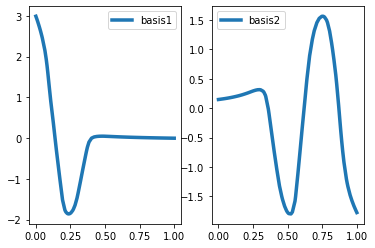

In [42]:
bases = plot_bases()

We can plot a linear combination of these two learned bases and see what it looks compared to the true one.

In [43]:
def plot(t, y, color, label):
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(grid, phi5(np.array(grid)), linewidth=3.5, color=color, label=label)
    plt.legend()

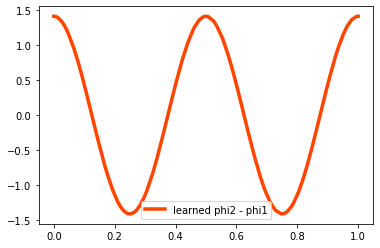

In [44]:
np_b = [np.array(b) for b in bases]
lin = np_b[1] - np_b[0]
plot(grid, lin, "orangered", "learned phi2 - phi1")

We can also plot the true signal $\phi_5$ in Case 3. We can see that two bases learned the truth successfully.

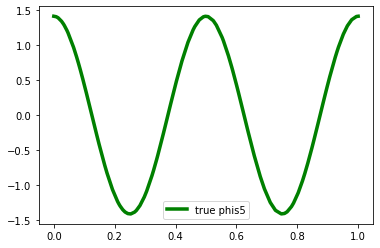

In [45]:
phi5 = _phi(5)
plot(grid, phi5(np.array(grid)), "green", "true phis5")